# Coding Challenge - Bitcoin Price

Objective:

Develop an automated and scalable process to obtain the 5-day moving
average of Bitcoin’s price during the first quarter of 2022.

## List of cryptocurrencies

Retrieve a list of all cryptocurrencies with id, name, and symbol (using the
CoinGecko API).

Coingecko has an API for querying the list of currencies it handles
https://docs.coingecko.com/reference/coins-list

In [ ]:
import requests
import logging

logging.basicConfig( # Log to safe messages and errors
    filename='./log/crypto_api_steps_ipynb.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

url = 'https://api.coingecko.com/api/v3/coins/list' # API link

logging.info('Starting conection ...')

try: 
    response = requests.get(url) # Conection and request
    coins = response.json()

    logging.info('Conection works!')

    data_coins = [{'id': record['id'], # Start with the request format 
                'name': record['name'],
                'symbol': record['symbol']}
                for record in coins[:][:]
                ]

except requests.exceptions.RequestException as e:
    logging.error(f'CoinGecko call fails: {e}')
    print('Something fails in the call')
except KeyError as e:
    logging.error(f'CoinGecko key missing: {e}')
    print('Something fails with the paramethers')
except Exception as e:
    logging.error(f'Unexpected error: {e}')
    print('Something fails unexpected')

### Result

In [2]:
data_coins[:10]

[{'id': '_', 'name': '༼ つ ◕_◕ ༽つ', 'symbol': 'gib'},
 {'id': '01coin', 'name': '01coin', 'symbol': 'zoc'},
 {'id': '0chain', 'name': 'Züs', 'symbol': 'zcn'},
 {'id': '0dog', 'name': 'Bitcoin Dogs', 'symbol': '0dog'},
 {'id': '0-knowledge-network', 'name': '0 Knowledge Network', 'symbol': '0kn'},
 {'id': '0-mee', 'name': 'O-MEE', 'symbol': 'ome'},
 {'id': '0vix-protocol', 'name': '0VIX Protocol', 'symbol': 'vix'},
 {'id': '0x', 'name': '0x Protocol', 'symbol': 'zrx'},
 {'id': '0x0-ai-ai-smart-contract',
  'name': '0x0.ai: AI Smart Contract',
  'symbol': '0x0'},
 {'id': '0x678-landwolf-1933', 'name': 'Landwolf', 'symbol': 'wolf'}]

##  ID de Bitcoin

Retrieve the Bitcoin coin id.

In [2]:
bitcoin_id = [coin['id'] for coin in data_coins if coin['name'].lower() == 'bitcoin'][0] # Filter for bitcoin in the list
print(bitcoin_id)

bitcoin


## Bitcoin's price 

Get Bitcoin’s price in USD and by date for the first quarter of 2022 (using the
CoinGecko API).


IMPORTANT: Because I'm using a DEMO API, can only have data from one year ago. So I have used the data from the first quarter of 2025

### Code with pandas

In [ ]:
import pandas as pd
import time
import os
import logging
from datetime import datetime, timedelta

logging.info('PANDAS WORKING')

os.environ['API_KEY'] = 'CG-iK1NXQDV8YPsEAJxTNTjJXL4' # Key from 
API_KEY = os.getenv('API_KEY')

start_date = '2025-01-01'
end_date = '2025-03-31'
window_time = 5
coin = 'bitcoin'
vs_currency = 'usd'

# Dates to UNIX
start_adjusted = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=window_time) # We will need data from the 5 previous days
start_ts = int(time.mktime(start_adjusted.timetuple()))
end_ts = int(time.mktime(datetime.strptime(end_date, '%Y-%m-%d').timetuple()))

# API definition
url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range?vs_currency={vs_currency}&from={start_ts}&to={end_ts}'
headers = {
    'accept': 'application/json',
    'x-cg-demo-api-key': API_KEY
    }

logging.info('Calling CoinGecko...')

try: 

    response = requests.get(url, headers=headers)
    data = response.json()

    logging.info('Conection works')
    logging.info('Start creating Dataframe')

    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df[['date', 'price']].drop_duplicates('date')
    df.sort_values('date', inplace=True)

except requests.exceptions.RequestException as e:
    logging.error(f'CoinGecko call fails: {e}')
    print('Something fails in the call')
except KeyError as e:
    logging.error(f'CoinGecko key missing: {e}')
    print('Something fails with the paramethers')
except Exception as e:
    logging.error(f'Unexpected error: {e}')
    print('Something fails unexpected')

#### Result

In [19]:
df

,date,price
0,2024-12-28,94331.947271
1,2024-12-29,95184.619453
2,2024-12-30,93663.447520
3,2024-12-31,92627.282131
4,2025-01-01,93507.858747
...,...,...
89,2025-03-27,86960.855549
90,2025-03-28,87227.271580
91,2025-03-29,84359.469155
92,2025-03-30,82679.172554


### Code with Spark (scalable)

In [2]:
import requests
import time
import os
import logging
from datetime import datetime, timedelta
from pyspark.sql import SparkSession # Using spark to manage the data from the API
from pyspark.sql.types import StructType, StructField, LongType, DoubleType
logging.info('SPARK WORKING')
logging.info('-------------API CONECTION-------------')

API_KEY = os.getenv('API_KEY')
JDBC_JAR = os.getenv('JDBC_JAR')

# IMPORTANT: The dates are in UTC timezone
start_date = '2025-01-01'
end_date = '2025-03-31'
window_time = 5
coin = 'bitcoin'
vs_currency = 'usd'

# Dates to UNIX
start_adjusted = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=window_time) # We will need data from the 5 previous days
start_ts = int(time.mktime(start_adjusted.timetuple()))
end_ts = int(time.mktime(datetime.strptime(end_date, '%Y-%m-%d').timetuple()))

# API definition
url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range?vs_currency={vs_currency}&from={start_ts}&to={end_ts}'
headers = {
    'accept': 'application/json',
    'x-cg-demo-api-key': API_KEY
    }

logging.info('Calling CoinGecko...')

try: 

    response = requests.get(url, headers=headers)
    data = response.json()

    logging.info('Conection works')
    logging.info('Start creating Dataframe')

    # Spark session
    spark = SparkSession.builder.appName('CoinGecko Data')  \
        .config('spark.jars', JDBC_JAR) \
        .getOrCreate()
    
    spark.conf.set('spark.sql.session.timeZone', 'UTC')

    # Schema
    schema = StructType([
        StructField('timestamp', LongType(), True),
        StructField('price', DoubleType(), True)
    ])

    # DataFrame
    df_spark = spark.createDataFrame(data['prices'], schema=schema)

    logging.info('Spark dataframe ready')

    
except requests.exceptions.RequestException as e:
    logging.error(f'CoinGecko call fails: {e}')
    print('Something fails in the call')
except KeyError as e:
    logging.error(f'CoinGecko key missing: {e}')
    print('Something fails with the paramethers')
except Exception as e:
    logging.error(f'Unexpected error: {e}')
    print('Something fails unexpected')

25/04/11 12:11:57 WARN Utils: Your hostname, MPVoting.local resolves to a loopback address: 127.0.0.1; using 192.168.1.15 instead (on interface en0)
25/04/11 12:11:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/04/11 12:11:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/11 12:11:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 64887)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/spark_test/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/anaconda3/envs/spark_test/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/anaconda3/envs/spark_test/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/anaconda3/envs/spark_test/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/anaconda3/envs/spark_test/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/anaconda3/envs/spark_test/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile i

#### Result

In [32]:
df_spark.show()

+-------------+------------------+
|    timestamp|             price|
+-------------+------------------+
|1735344000000| 94331.94727053077|
|1735430400000| 95184.61945288602|
|1735516800000| 93663.44751964067|
|1735603200000| 92627.28213113277|
|1735689600000| 93507.85874741491|
|1735776000000|  94384.1761153871|
|1735862400000| 96852.14681235075|
|1735948800000| 98084.34279280754|
|1736035200000| 98256.73876849933|
|1736121600000| 98364.58946599838|
|1736208000000|102229.39453189743|
|1736294400000| 96952.09886774956|
|1736380800000| 95016.71440989176|
|1736467200000| 92376.27578346101|
|1736553600000|  94736.6267420969|
|1736640000000| 94559.55167224213|
|1736726400000| 94454.77089638807|
|1736812800000|  94456.3493746993|
|1736899200000| 96574.07768799194|
|1736985600000|100313.15239828422|
+-------------+------------------+
only showing top 20 rows



## Save data

Save the data in the database of your choice.

### Code with Pandas

In [ ]:
import sqlite3

logging.info('PANDAS WORKING')
# Saving on SQLite
conn = sqlite3.connect('./db/bitcoin_prices.db')
df.to_sql('btc_prices', conn, if_exists='replace', index=False)

94

### Code with Spark

In [ ]:
from pyspark.sql.functions import date_format, to_timestamp, col

jdbc_url = 'jdbc:sqlite:./db/bitcoin_prices.db'
logging.info('SPARK WORKING')
logging.info('-------------SAVE DATA-------------')

try:
    logging.info('Starting saving in to DB...')
    # IMPORTANT: The dates are in UTC timezone
    df_spark.withColumn('date', (col('timestamp')/1000).cast('timestamp')) \
        .withColumn('date', date_format('date', 'yyyy-MM-dd HH:mm:ssZ')) \
        .select('date', 'price') \
        .write.format('jdbc') \
        .option('url', jdbc_url) \
        .option('dbtable', 'btc_prices_v2') \
        .option('driver', 'org.sqlite.JDBC') \
        .mode('overwrite') \
        .save()
    
    logging.info('Data successfully saved')
    print('Data successfully saved')

except Exception as e:
    logging.error(f'Unexpected error: {e}')
    print(f'Something fails {e}')

Data successfully saved


25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8
25/04/11 12:12:38 WARN J

## 5-day moving average

Use the data previously stored in the database to calculate the 5-day
moving average using a window/partition function in Python (you may
use either pandas or PySpark).

Using pyspark for extra point

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min as min_
from pyspark.sql.window import Window
from datetime import timedelta
import pandas as pd

jdbc_url = 'jdbc:sqlite:./db/bitcoin_prices.db'
logging.info('-------------5 DAY AVG-------------')

try: 
    logging.info('Conecting to the DB...')

    df_spark = spark.read.format('jdbc') \
        .option('url', jdbc_url) \
        .option('dbtable', 'btc_prices_v2') \
        .option('driver', 'org.sqlite.JDBC') \
        .load()

    logging.info('Conection works')

    df_spark = df_spark.withColumn('date', col('date').cast('timestamp'))

    window_spec = Window.orderBy('date').rowsBetween(-5 + 1, 0)
    df_spark_ma = df_spark.withColumn('5_day_ma', avg('price').over(window_spec))

    date_min= df_spark_ma.select(min_('date').alias('date_min')).collect()
    lower_date = date_min[0]['date_min']
    start_date = lower_date + timedelta(days=5)

    logging.info('Finish the window creation. Save data to DB...')

    # Save in DB for visualization
    # IMPORTANT: The dates are in CST timezone
    df_spark_ma.filter(col('date') >= start_date) \
        .withColumn('date', date_format('date', 'yyyy-MM-dd HH:mm:ss')) \
        .select('date', 'price', '5_day_ma') \
        .write \
        .format('jdbc') \
        .option('url', jdbc_url) \
        .option('dbtable', 'btc_ma_5d') \
        .option('driver', 'org.sqlite.JDBC') \
        .mode('overwrite') \
        .save()

    logging.info('The data is update')
    
except Exception as e:
    logging.error(f'Unexpected error: {e}')
    print(f'Something fails unexpected {e}')

25/04/11 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/11 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/11 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/11 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/11 12:12:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/11 12:12:48 WARN JdbcUtils: Requested isolation level 1 is not supported; falling back to default isolation level 8


## Visualization

Use a tool of your choice to visualize the results in a graph
(Extra point).

In [29]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

con = sqlite3.connect('./db/bitcoin_prices.db')

df = pd.read_sql_query('SELECT date(date) as dt, * from btc_ma_5d ORDER BY dt limit 100', con)
last = len(df['dt'])
last_day = df['dt'][last-1].replace('-','_')

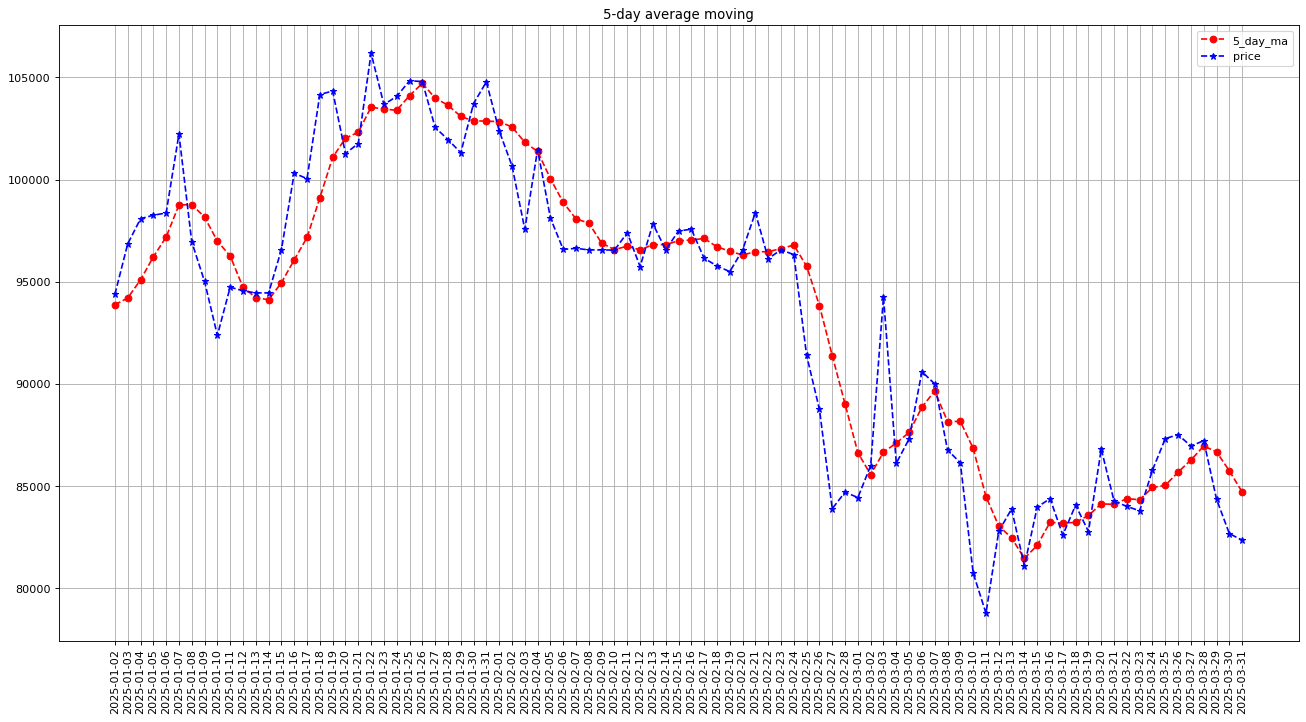

In [32]:
figure(figsize=(20, 10), dpi=80)
plt.grid(True)
plt.title('5-day average moving')
plt.plot(df['dt'], df['5_day_ma'], color='red', linestyle='--', marker='o', label='5_day_ma')
plt.plot(df['dt'], df['price'], color='blue', linestyle='--', marker='*', label='price')
plt.tick_params(axis='x', rotation=90)
plt.savefig(f'./graphics/5_day_average_moving_{last_day}.jpg')
plt.legend()